# LSTMのテストコードを走らせてみる
* http://kivantium.hateblo.jp/entry/2016/01/31/222050
* 上記記事を参照します
* Chainer1.6になってから、LSTM周りの仕様が大きく変わり、参考になる情報が少なくなってしまった

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import math
import sys
import time

import numpy as np
from numpy.random import *
import six

import chainer
from chainer import optimizers
from chainer import serializers
import chainer.functions as F
import chainer.links as L
from chainer import cuda

import matplotlib.pyplot as plt

## タスク

* このタスクはa1,a2,⋯,ap−1とx,yというp+1種類のデータを用意して、
* (y,a1,a2,⋯,ap−1,y)
* (x,a1,a2,⋯,ap−1,x)
* という2つの文字列を学習させた後、文字列の最初から順に1文字ずつ与えて次の文字を予測させる

* 2つの文字列は最初と最後の文字以外は全て同じなので、最後の1文字を当てるためには最初の1文字を最後まで記憶しておく必要がある
* pが大きくなるほど保持しなければならない期間が長くなるので難しい

## LSTMのネットワーク定義

* L.EmbedID : 数字で与えたラベルをin_size次元(単語などのID数)の1-of-k法で表現したあと重みを掛けてn_units次元ベクトルとして出力
* Linear : n_units次元の入力に重みを掛けてin_size次元のベクトルを出力

In [3]:
class LSTM(chainer.Chain):
    def __init__(self, p, n_units, train=True):
        super(LSTM, self).__init__(
            embed=L.EmbedID(p+1, n_units),
            l1=L.LSTM(n_units, n_units),
            l2=L.Linear(n_units, p+1),
        )

    def __call__(self, x):
        h0 = self.embed(x)
        h1 = self.l1(h0)
        y = self.l2(h1)
        return y

    def reset_state(self):
        self.l1.reset_state()

## パラメータ設定

* GPUのIDは直接指定

In [4]:
# 引数の処理
#parser = argparse.ArgumentParser()
#parser.add_argument('--gpu', '-g', default=-1, type=int,
#                    help='GPU ID (negative value indicates CPU)')
#args = parser.parse_args()
gpu = 1

In [30]:
# パラメータ設定
p = 10          # 文字列長
n_units = 4    # 隠れ層のユニット数
training_num = 50000 # 学習回数


## 訓練データの準備

* 上記「タスク」にあるように、最初と最後の文字だけ違う二つの文字列ベクトルを用意する

In [31]:
# train_data[0]がy、train_data[1]がxの方
# a_1を0にしたので添字がひとつずれている
train_data = np.ndarray((2, p+1), dtype=np.int32)
train_data[0][0] = train_data[0][p] = p
train_data[1][0] = train_data[1][p] = p-1
for i in range(p-1):
    train_data[0][i+1] = i
    train_data[1][i+1] = i


In [32]:
# 訓練データの表示
print(train_data[0])
print(train_data[1])


[10  0  1  2  3  4  5  6  7  8 10]
[9 0 1 2 3 4 5 6 7 8 9]


## モデルの準備

In [33]:
# モデルの準備
lstm = LSTM(p , n_units)


# Classifierを定義する
model = L.Classifier(lstm)

model.compute_accuracy = False
for param in model.params():
    data = param.data
    data[:] = np.random.uniform(-0.2, 0.2, data.shape)


In [34]:
lstm.embed.W.data.shape

(11, 4)

In [35]:
xp = cuda.cupy
cuda.get_device(gpu).use()
model.to_gpu()


## 学習

In [36]:
# optimizerの設定
optimizer = optimizers.Adam()
optimizer.setup(model)

In [ ]:
loss_arc = []
# 訓練を行うループ
display = 1000  # 何回ごとに表示するか
total_loss = 0  # 誤差関数の値を入れる変数
for seq in range(training_num):
    sequence = train_data[randint(2)] # ランダムにどちらかの文字列セットを選ぶ
    lstm.reset_state()  # 前の系列の影響がなくなるようにリセット
    for i in six.moves.range(p):
        x = chainer.Variable(xp.asarray([sequence[i]]))   # i文字目を入力に
        t = chainer.Variable(xp.asarray([sequence[i+1]])) # i+1文字目を正解に
        loss = model(x, t)  # lossの計算

        # 出力する時はlossを記憶
        if seq%display==0:
            total_loss += loss.data.get()

        # 最適化の実行
        model.zerograds()
        loss.backward()
        optimizer.update()

    # lossの表示
    if seq%display==0:
        print("sequence:{}, loss:{}".format(seq, total_loss))
        loss_arc.append(total_loss)
        total_loss = 0
    # 10回に1回系列ごとの予測結果と最後の文字の確率分布を表示
    if seq%(display)==0:
        for select in six.moves.range(2):
            sequence = train_data[select]
            lstm.reset_state()
            print("prediction: {},".format(sequence[0]), end="")
            for i in six.moves.range(p):
                x = chainer.Variable(xp.asarray([sequence[i]]))
                data = lstm(x).data
                print("{},".format(np.argmax(data)), end="")
            print()
            print("probability: {}".format(data))

sequence:0, loss:23.9075202942
prediction: 10,6,6,6,6,6,6,6,6,6,6,
probability: [[ 0.17058513  0.10007756  0.15955317 -0.06852227 -0.02075332 -0.15343508
   0.19234739  0.05221293 -0.14084359 -0.0384732  -0.18381624]]
prediction: 9,6,6,6,6,6,6,6,6,6,6,
probability: [[ 0.17058153  0.10007981  0.15955177 -0.06852208 -0.02075576 -0.15343513
   0.19234458  0.05221019 -0.14084148 -0.03847122 -0.18381606]]
sequence:1000, loss:2.68354868889
prediction: 10,0,1,2,3,4,5,6,7,8,9,
probability: [[ 0.77676749  0.50760055 -6.50588655  0.19948769 -3.10865641  0.66895431
  -0.99069685 -2.28104138  1.98794174  4.03071404  3.96560502]]
prediction: 9,0,1,2,3,4,5,6,7,8,9,
probability: [[ 0.77676749  0.50760078 -6.50588608  0.19948769 -3.10865641  0.66895419
  -0.99069661 -2.28104138  1.98794174  4.03071404  3.96560502]]
sequence:2000, loss:0.984230518341
prediction: 10,0,1,2,3,4,5,6,7,8,10,
probability: [[ -0.47764057   0.40707994 -12.17298222   0.3687565   -4.95233059
    1.70298135  -4.06179714  -4.96574

[]

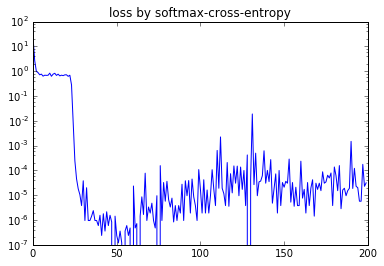

In [40]:
# Lossの変化をグラフ描画する
plt.plot(range(len(loss_arc)), loss_arc, color="#0000FF")
plt.yscale('log')
#plt.legend(["Generator", "Discriminator"],loc=4)
plt.title("loss by softmax-cross-entropy")
plt.plot()

In [1]:
loss_arc

NameError: name 'loss_arc' is not defined